# Dataset Exploration - Binary Image Classification

Quick exploration of the image dataset before building the classifier. Need to understand what we're working with first.

In [27]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torchvision.transforms import functional
from torchvision import transforms
import PIL
import glob
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import random
from PIL import Image
import os

## 1. Data Overview

Let's see what we have - should be 100k training images and 20k test images.

In [28]:
# Load image paths
train_img_path = glob.glob(r"C:\Users\felme\Downloads\ml_exercise_therapanacea\data\train_img\*.jpg")
val_img_path = glob.glob(r"C:\Users\felme\Downloads\ml_exercise_therapanacea\data\val_img\*.jpg")

print(f"Training images: {len(train_img_path)}")
print(f"Test images: {len(val_img_path)}")

# Quick sanity check on filenames
print(f"\nFirst few training files: {[os.path.basename(p) for p in train_img_path[:5]]}")
print(f"Last few training files: {[os.path.basename(p) for p in train_img_path[-5:]]}")

Training images: 100000
Test images: 20000

First few training files: ['000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg']
Last few training files: ['099996.jpg', '099997.jpg', '099998.jpg', '099999.jpg', '100000.jpg']


## 2. Image Properties

Let's check what kind of images we're dealing with.

In [29]:
# Check a few random images for basic properties
sample_paths = random.sample(train_img_path, 5)

print("Sample image properties:")
for i, path in enumerate(sample_paths):
    img = PIL.Image.open(path)
    print(f"Image {i+1}: Size {img.size}, Mode: {img.mode}")

# Check one specific image in detail
test_image = PIL.Image.open(r"C:\Users\felme\Downloads\ml_exercise_therapanacea\data\val_img\000247.jpg")
num_channels = functional.get_image_num_channels(test_image)
print(f"\nTest image channels: {num_channels}")
print(f"Test image size: {test_image.size}")

Sample image properties:
Image 1: Size (64, 64), Mode: RGB
Image 2: Size (64, 64), Mode: RGB
Image 3: Size (64, 64), Mode: RGB
Image 4: Size (64, 64), Mode: RGB
Image 5: Size (64, 64), Mode: RGB

Test image channels: 3
Test image size: (64, 64)


## 3. Labels Analysis

Now let's look at the labels and see what we're classifying.

In [30]:
# Read labels
labels = pd.read_csv(r"C:\Users\felme\Downloads\ml_exercise_therapanacea\data\label_train.txt", 
                     sep="\t", header=None)
labels.columns = ["label"]

print("Label file info:")
print(f"Shape: {labels.shape}")
print(f"\nFirst few labels:")
print(labels.head())
print(f"\nLast few labels:")
print(labels.tail())

Label file info:
Shape: (100000, 1)

First few labels:
   label
0      1
1      1
2      1
3      1
4      1

Last few labels:
       label
99995      1
99996      1
99997      1
99998      1
99999      1


In [31]:
# Check label distribution
print("Label distribution:")
label_counts = labels["label"].value_counts().sort_index()
print(label_counts)
print(f"\nClass balance:")
for label, count in label_counts.items():
    percentage = (count / len(labels)) * 100
    print(f"Class {label}: {count} images ({percentage:.1f}%)")

Label distribution:
label
0    12102
1    87898
Name: count, dtype: int64

Class balance:
Class 0: 12102 images (12.1%)
Class 1: 87898 images (87.9%)


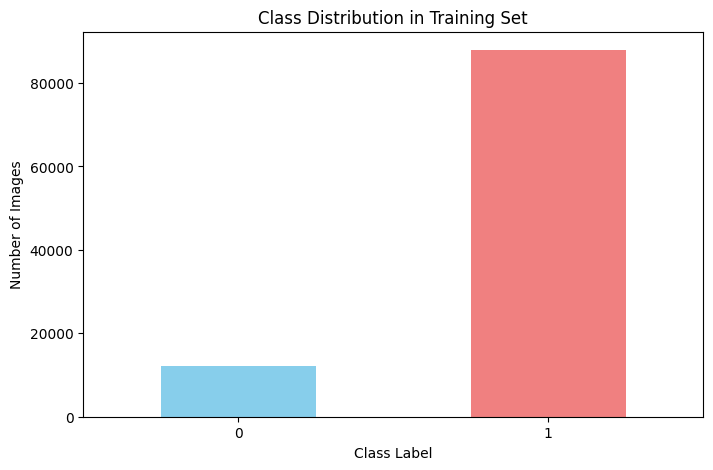

In [32]:
# Visualize distribution
plt.figure(figsize=(8, 5))
labels["label"].value_counts().sort_index().plot(kind="bar", color=['skyblue', 'lightcoral'])
plt.title("Class Distribution in Training Set")
plt.xlabel("Class Label")
plt.ylabel("Number of Images")
plt.xticks(rotation=0)
plt.show()

# This will tell us if we have class imbalance issues

## 4. Image-Label Mapping Check

This is crucial - need to make sure the image filenames match up with the label file correctly.

In [33]:
# Sort paths to ensure proper order
train_img_path_sorted = sorted(train_img_path, key=lambda x: int(os.path.basename(x).split('.')[0]))

print("Checking image-label mapping:")
print("First 10 mappings:")
for i in range(10):
    img_name = os.path.basename(train_img_path_sorted[i])
    img_number = int(img_name.split('.')[0])
    label = labels.iloc[i]['label']
    print(f"Image: {img_name} (#{img_number}) -> Label: {label}")

# Check if image numbers match their position in label file
print("\nChecking alignment...")
mismatches = 0
for i in range(min(1000, len(train_img_path_sorted))):  # Check first 1000
    img_name = os.path.basename(train_img_path_sorted[i])
    img_number = int(img_name.split('.')[0])
    expected_number = i + 1  # Images start from 000001.jpg
    if img_number != expected_number:
        mismatches += 1
        if mismatches <= 5:  # Show first few mismatches
            print(f"Mismatch: {img_name} at position {i}, expected {expected_number:06d}.jpg")

if mismatches == 0:
    print("Image numbering matches label file order perfectly")
else:
    print(f"Found {mismatches} mismatches in first 1000 images")

Checking image-label mapping:
First 10 mappings:
Image: 000001.jpg (#1) -> Label: 1
Image: 000002.jpg (#2) -> Label: 1
Image: 000003.jpg (#3) -> Label: 1
Image: 000004.jpg (#4) -> Label: 1
Image: 000005.jpg (#5) -> Label: 1
Image: 000006.jpg (#6) -> Label: 1
Image: 000007.jpg (#7) -> Label: 1
Image: 000008.jpg (#8) -> Label: 1
Image: 000009.jpg (#9) -> Label: 1
Image: 000010.jpg (#10) -> Label: 1

Checking alignment...
Image numbering matches label file order perfectly


## 5. Visual Sample Exploration

Let's look at some actual images to get a feel for the data.

In [ ]:
# Sample images from each class
class_0_indices = labels[labels['label'] == 0].index[:5].tolist()
class_1_indices = labels[labels['label'] == 1].index[:5].tolist()

plt.figure(figsize=(15, 8))

# Show Class 0 samples
plt.suptitle("Sample Images by Class", fontsize=16)
for i, idx in enumerate(class_0_indices):
    img_path = train_img_path_sorted[idx]
    img = Image.open(img_path)
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f"Class 0\n({os.path.basename(img_path)})")
    plt.axis('off')

# Show Class 1 samples  
for i, idx in enumerate(class_1_indices):
    img_path = train_img_path_sorted[idx]
    img = Image.open(img_path)
    plt.subplot(2, 5, i+6)
    plt.imshow(img)
    plt.title(f"Class 1\n({os.path.basename(img_path)})")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Random sample across all data
sample_indices = random.sample(range(len(train_img_path_sorted)), 10)

plt.figure(figsize=(15, 6))
for i, idx in enumerate(sample_indices):
    img_path = train_img_path_sorted[idx]
    img = Image.open(img_path)
    label = labels.iloc[idx]['label']
    
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f"Class {label}\n{os.path.basename(img_path)}")
    plt.axis('off')

plt.suptitle("Random Sample from Dataset", fontsize=16)
plt.tight_layout()
plt.show()

## REMARKS

Trainig data label are not labeled corretly! maybe it's meant to like like real world data!!

## 6. Image Size Analysis

Important to know what sizes we're dealing with for preprocessing.

In [36]:
# Check image sizes across a sample
sample_size = 100
sample_indices = random.sample(range(len(train_img_path_sorted)), sample_size)

sizes = []
for idx in sample_indices:
    img_path = train_img_path_sorted[idx]
    img = Image.open(img_path)
    sizes.append(img.size)

# Analyze sizes
widths = [s[0] for s in sizes]
heights = [s[1] for s in sizes]

print(f"Image size analysis (sample of {sample_size} images):")
print(f"Width - Min: {min(widths)}, Max: {max(widths)}, Mean: {np.mean(widths):.1f}")
print(f"Height - Min: {min(heights)}, Max: {max(heights)}, Mean: {np.mean(heights):.1f}")
print(f"\nMost common sizes:")
size_counts = {}
for size in sizes:
    size_counts[size] = size_counts.get(size, 0) + 1

for size, count in sorted(size_counts.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"{size}: {count} images")

Image size analysis (sample of 100 images):
Width - Min: 64, Max: 64, Mean: 64.0
Height - Min: 64, Max: 64, Mean: 64.0

Most common sizes:
(64, 64): 100 images


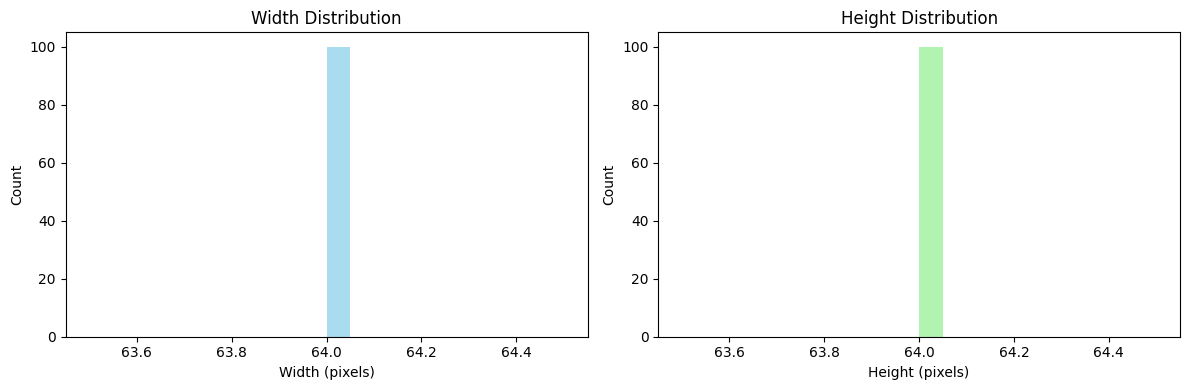

In [37]:
# Visualize size distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(widths, bins=20, alpha=0.7, color='skyblue')
plt.title('Width Distribution')
plt.xlabel('Width (pixels)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(heights, bins=20, alpha=0.7, color='lightgreen')
plt.title('Height Distribution')
plt.xlabel('Height (pixels)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()